## Import statements

In [28]:
import torch
from torch import nn
import inspect
import logging
from transformers import PreTrainedTokenizerFast
from torch.nn.utils import clip_grad_norm_
from transformers import get_cosine_schedule_with_warmup
from torch.amp import autocast, GradScaler
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
)

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

device = "cuda"

## Decoder block architecture

In [29]:
class CasualMaskedDecoderBlocks(nn.Module):
    def __init__(
            self,
            embed_dim: int,
            num_heads: int,
            num_blocks: int,
            max_seq_len: int,
            dropout: float = 0.0,
            activation_function: str = "gelu",
            ffw_network_multiplier: int = 4,
    ):
        """
        :param embed_dim: Embedding dimension of the tokens in the sequence.
        :param num_heads: Number of heads in each decoder block.
        :param num_blocks: Number of decoder blocks.
        :param dropout: Probability of dropout.
        :param max_seq_len: Maximum expected sequence length.
        :param ffw_network_multiplier: multiplier for embed_dim to get the dimensionality for the feedforward network.
        """
        super().__init__()

        assert embed_dim % num_heads == 0, f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: embed_dim ({embed_dim}) is not divisible by num_heads ({num_heads})'

        assert activation_function in ("relu",
                                       "gelu"), f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: activation_function expected to be "relu"/"gelu", received "{activation_function}" instead'

        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim

        block = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ffw_network_multiplier * embed_dim,
            dropout=dropout,
            activation=activation_function,
            batch_first=True,
            norm_first=True
        )

        self.blocks = nn.ModuleList([block for _ in range(num_blocks)])

        causal = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer("causal_mask", causal)

    def forward(self, tok_seq, padding_mask=None) -> torch.Tensor:
        """
        :param tok_seq: torch.Tensor of size [batch, seq_len, embed_dim] representing the pre-attended token sequence.
        :param padding_mask: Bool mask of size [batch, seq_len]; True for padding tokens.
        :return: Attended token sequence after num_blocks amount of decoder blocks.
        """
        assert tok_seq.dim() == 3, f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: tok_seq tensor should be of size [batch, seq_len, embed_dim], received a tensor with {tok_seq.dim()} dimensions instead'
        batch_size, seq_len, embed_dim = tok_seq.size()
        assert seq_len <= self.max_seq_len, f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: length of inputted sequence ({seq_len}) exceeds maximum expected sequence length ({self.max_seq_len})'
        assert embed_dim == self.embed_dim, f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: received embed_dim ({embed_dim}) does not match the expected embed_dim ({self.embed_dim})'
        if padding_mask is not None:
            assert padding_mask.dim() == 2, f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: padding_mask tensor should be of size [batch, seq_len], received a tensor with {padding_mask.dim()} dimensions instead'
            pm_batch_size, pm_seq_len = padding_mask.size()
            assert batch_size == pm_batch_size and seq_len == pm_seq_len, f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: dimension mismatch between tok_seq ([{batch_size},{seq_len},{embed_dim}]) and padding_mask ([{pm_batch_size}, {pm_seq_len}])'

        casual_mask = self.causal_mask[:seq_len, :seq_len]

        for block in self.blocks:
            tok_seq = block(
                src=tok_seq,
                src_mask=casual_mask,
                src_key_padding_mask=padding_mask
            )

        return tok_seq

## Attended token decoder

In [30]:
class AttendedTokenDecoder(nn.Module):
    def __init__(
            self,
            embed_dim: int,
            vocabulary_size: int,
    ):
        """
        :param embed_dim:
        :param vocabulary_size:
        """
        super().__init__()

        self.embed_dim = embed_dim
        self.vocabulary_size = vocabulary_size

        self.decoder = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=vocabulary_size)
        )

    def forward(self, att_tok_seq):
        """
        :param att_tok_seq:
        :return:
        """
        assert att_tok_seq.dim() == 3, f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: att_tok_seq tensor should be of size [batch, seq_len, embed_dim], received a tensor with {att_tok_seq.dim()} dimensions instead'

        batch_size, seq_len, embed_dim = att_tok_seq.size()

        assert embed_dim == self.embed_dim, f'{self.__class__.__name__}.{inspect.currentframe().f_code.co_name}: received embed_dim ({embed_dim}) does not match expected embed_dim ({self.embed_dim})'

        token_logits = self.decoder(att_tok_seq)

        return token_logits

## Combined GPT model

In [31]:
class GPTModel(nn.Module):
    def __init__(
            self,
            embed_dim: int,
            num_heads: int,
            num_blocks: int,
            max_seq_len: int,
            vocab_size: int,
            tokenizer,
            dropout: float = 0.0,
            activation_function: str = "gelu",
            ffw_network_multiplier: int = 4,
    ):
        """
        :param embed_dim:
        :param num_heads:
        :param num_blocks:
        :param max_seq_len:
        :param vocab_size:
        :param tokenizer:
        :param dropout:
        :param activation_function:
        :param ffw_network_multiplier:
        """
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.activation_function = activation_function
        self.ffw_network_multiplier = ffw_network_multiplier

        self.pad_token_id = tokenizer.pad_token_id

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_embedding = nn.Embedding(max_seq_len, embed_dim)

        self.decoder_blocks = CasualMaskedDecoderBlocks(
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_blocks=num_blocks,
            max_seq_len=max_seq_len,
            dropout=dropout,
            activation_function=activation_function,
            ffw_network_multiplier=ffw_network_multiplier,
        )

        self.decoder = AttendedTokenDecoder(
            embed_dim=embed_dim,
            vocabulary_size=vocab_size,
        )

    def forward(self, tokenized_sequence):
        """
        :param tokenized_sequence:
        :return:
        """
        padding_mask = tokenized_sequence.eq(self.pad_token_id)

        batch_size, seq_length = tokenized_sequence.size()

        embedded_sequence = self.token_embedding(tokenized_sequence)

        position_ids = (
            torch.arange(seq_length, device=embedded_sequence.device)
            .unsqueeze(0)
            .expand(batch_size, seq_length)
        )
        positional_embeddings = self.positional_embedding(position_ids)

        sequence = embedded_sequence + positional_embeddings

        sequence = self.decoder_blocks(sequence, padding_mask)

        logits = self.decoder(sequence)

        return logits

## Initialization

In [32]:
tokenizer_model_path = "../../../saved_models/tokenizers/fineweb/fineweb_v0"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_path)

EMBED_DIM = 768
NUM_HEADS = 4
NUM_BLOCKS = 4
MAX_SEQ_LENGTH = 512
VOCAB_SIZE = len(tokenizer.get_vocab())

model = GPTModel(
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    max_seq_len=MAX_SEQ_LENGTH,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    dropout=0.0,
).to(device)

In [33]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total: {total_params:,}")
print(f"Trainable: {total_params:,}")

Total: 84,331,088
Trainable: 84,331,088


## Data loading

In [34]:
import duckdb
import torch
from torch.utils.data import IterableDataset
from transformers import PreTrainedTokenizerFast


class ChunkedFineWebDataset(IterableDataset):
    def __init__(
            self,
            db_path: str,
            tokenizer: PreTrainedTokenizerFast,
            split: str = "train",
            val_mod: int = 0,
            num_buckets: int = 10,
            samples_per_epoch: int = 10,
            batch_size: int = 16,
            max_length: int = 512,
            stride: int = 256,
    ):
        """
        Yields lists of token IDs of length <= max_length+1.
        """
        self.db_path = db_path
        self.tokenizer = tokenizer
        self.split = split
        self.val_mod = val_mod
        self.num_buckets = num_buckets
        self.samples_per_epoch = samples_per_epoch
        self.batch_size = batch_size
        self.max_length = max_length
        self.stride = stride

    def __iter__(self):
        conn = duckdb.connect(self.db_path)
        if self.split == "train":
            where = f"abs(hash(id)) % {self.num_buckets} != {self.val_mod}"
        else:
            where = f"abs(hash(id)) % {self.num_buckets} = {self.val_mod}"

        batches = self.samples_per_epoch // self.batch_size
        for _ in range(batches):
            # reservoir‐sample exactly batch_size rows
            query = f"""
            SELECT text
            FROM fineweb
            TABLESAMPLE RESERVOIR({self.batch_size})
            WHERE {where}
            """
            rows = conn.execute(query).fetchall()

            # fallback if reservoir returns fewer rows (rare)
            if len(rows) < self.batch_size:
                rows = conn.execute(f"""
                  SELECT text
                  FROM fineweb
                  WHERE {where}
                  LIMIT {self.batch_size}
                """).fetchall()

            for (txt,) in rows:
                txt = txt.replace("\n", " ").strip()
                token_ids = self.tokenizer.encode(txt)
                start = 0
                while start < len(token_ids):
                    window = token_ids[start: start + self.max_length + 1]
                    if len(window) < 2:
                        break
                    yield window
                    start += (self.max_length - self.stride)

        conn.close()

    def __len__(self):
        # #windows is approximate: (samples_per_epoch * avg_tokens) / (max_length-stride)
        return (self.samples_per_epoch // self.batch_size) * self.batch_size


from torch.nn.utils.rnn import pad_sequence


class ChunkedCollator:
    def __init__(self, pad_token_id: int):
        self.pad_token_id = pad_token_id

    def __call__(self, batch):
        # batch: List[List[int]] of length BATCH_SIZE
        input_ids = [torch.tensor(ids[:-1], dtype=torch.long) for ids in batch]
        labels = [torch.tensor(ids[1:], dtype=torch.long) for ids in batch]

        # pad to longest in batch
        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=self.pad_token_id)
        labels = pad_sequence(labels, batch_first=True, padding_value=-100)

        return {"input_ids": input_ids, "labels": labels}


from torch.utils.data import DataLoader

BATCH_SIZE = 8
SAMPLES_PE = 128

# 2) Datasets
train_ds = ChunkedFineWebDataset(
    db_path="../../data/fineweb/fineweb.db",
    tokenizer=tokenizer,
    split="train",
    samples_per_epoch=SAMPLES_PE,
    batch_size=BATCH_SIZE,
    max_length=MAX_SEQ_LENGTH,
    stride=256
)
val_ds = ChunkedFineWebDataset(
    db_path="../../data/fineweb/fineweb.db",
    tokenizer=tokenizer,
    split="val",
    samples_per_epoch=SAMPLES_PE,  # smaller val
    batch_size=BATCH_SIZE,
    max_length=MAX_SEQ_LENGTH,
    stride=256
)

# 3) Collator
collator = ChunkedCollator(pad_token_id=tokenizer.pad_token_id)

# 4) DataLoaders
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collator)
valid_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collator)

## How to save stuff

In [35]:
from datetime import datetime


def save_model(curr_epoch):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    torch.save(model.state_dict(), f"../../../saved_models/models/fineweb_v0/E{curr_epoch}-{timestamp}")


## Training loop

In [36]:
import torch.nn.functional as F
from torch.distributions import Categorical

NUM_EPOCHS = 100
LEARNING_RATE = 0.001

scaler = GradScaler()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

num_training_steps = NUM_EPOCHS * len(train_dataloader)
num_warmup_steps = int(0.1 * num_training_steps)

# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=num_warmup_steps,
#     num_training_steps=num_training_steps,
#     num_cycles=0.5
# )

train_losses = []
valid_losses = []
learning_rates = []
train_entropies = []
valid_entropies = []

model.train()
optimizer.zero_grad()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {(epoch + 1)}/{NUM_EPOCHS} - {((epoch + 1) / NUM_EPOCHS) * 100:.3f}%", end=" | ")

    train_loss = 0
    train_entropy = 0
    skipped = 0

    for index, batch in enumerate(train_dataloader):
        # last_lr = scheduler.get_last_lr()[0]
        last_lr = LEARNING_RATE
        learning_rates.append(last_lr)
        # if (index + 1) % 50 == 0:
        #   print(f"\tCurrent LR: {last_lr:10f}")

        input_ids = batch["input_ids"].to(device)
        if input_ids.size(0) != BATCH_SIZE:
            skipped += 1
            continue
        labels = batch["labels"].to(device)

        with autocast("cuda"):
            logits = model(input_ids)
            probability_dist = F.softmax(logits[:, -1, :], dim=-1)
            entropy = torch.mean(Categorical(probs=probability_dist).entropy())
            train_entropy += entropy.item()
            loss = loss_fn(
                logits.view(-1, len(tokenizer.get_vocab())),
                labels.view(-1)
            )

        train_loss += loss.item()
        scaler.scale(loss).backward()

    effective_train_dataloader_length = len(train_dataloader) - skipped
    loss /= effective_train_dataloader_length
    scaler.unscale_(optimizer)
    # clip_grad_norm_(model.parameters(), max_norm=1.0)
    scaler.step(optimizer)
    scaler.update()
    # scheduler.step()
    optimizer.zero_grad()

    train_loss /= effective_train_dataloader_length
    train_losses.append(train_loss)
    train_entropy /= effective_train_dataloader_length
    train_entropies.append(train_entropy)

    print(f"Train Loss: {train_loss:.5f} E {train_entropy:5f}", end=" | ")

    # print(f"\tDataloader length = {index}")

    valid_loss = 0
    valid_entropy = 0
    skipped = 0

    for index, batch in enumerate(valid_dataloader):
        input_ids = batch["input_ids"].to(device)
        if input_ids.size(0) != BATCH_SIZE:
            skipped += 1
            continue
        labels = batch["labels"].to(device)

        with autocast("cuda"):
            logits = model(input_ids)
            probability_dist = F.softmax(logits[:, -1, :], dim=-1)
            entropy = torch.mean(Categorical(probs=probability_dist).entropy())
            valid_entropy += entropy.item()
            loss = loss_fn(
                logits.view(-1, len(tokenizer.get_vocab())),
                labels.view(-1)
            )

        valid_loss += loss.item()

    effective_valid_dataloader_length = len(valid_dataloader) - skipped
    valid_loss /= effective_valid_dataloader_length
    valid_losses.append(valid_loss)
    valid_entropy /= effective_valid_dataloader_length
    valid_entropies.append(valid_entropy)

    print(f"Valid Loss: {valid_loss:.5f} E {valid_entropy:5f}")

    if (valid_loss) < 1:
        save_model(epoch)
        print(f"\tModel saved")

Epoch 1/100 - 1.000% | Train Loss: 30.13343 E 27.718773 | Valid Loss: 27.61991 E 16.666009
Epoch 2/100 - 2.000% | Train Loss: 25.09999 E 14.562844 | Valid Loss: 27.61991 E 16.666009
Epoch 3/100 - 3.000% | Train Loss: 27.05537 E 15.854138 | Valid Loss: 28.26065 E 26.779720
Epoch 4/100 - 4.000% | Train Loss: 22.38581 E 23.393963 | Valid Loss: 25.89470 E 23.300670
Epoch 5/100 - 5.000% | Train Loss: 27.27551 E 26.998872 | Valid Loss: 24.10026 E 22.306184
Epoch 6/100 - 6.000% | Train Loss: 21.51343 E 23.664034 | Valid Loss: 23.91971 E 10.540350
Epoch 7/100 - 7.000% | Train Loss: 23.04672 E 13.639088 | Valid Loss: 23.46639 E 24.895460
Epoch 8/100 - 8.000% | Train Loss: 15.23377 E 22.252944 | Valid Loss: 23.38936 E 18.341870
Epoch 9/100 - 9.000% | Train Loss: 18.88044 E 20.437703 | Valid Loss: 23.68820 E 16.116577
Epoch 10/100 - 10.000% | Train Loss: 10.38426 E 13.292934 | Valid Loss: 22.92441 E 19.494546
Epoch 11/100 - 11.000% | Train Loss: 17.02438 E 19.508179 | Valid Loss: 22.80464 E 24.19

2025-04-10 01:33:07,112 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-10 01:33:07,113 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-10 01:33:07,115 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-04-10 01:33:07,116 - DEBUG - findfont: score(FontEntry(fname='/home/yegor/miniconda3/envs/ptorch/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2025-04-10 01:33:07,116 - DEBUG - findfont: score(FontEntry(fname='/home/yegor/miniconda3/envs/ptorch/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-04-10 01:33:07,116 - DEBUG - findfont: 

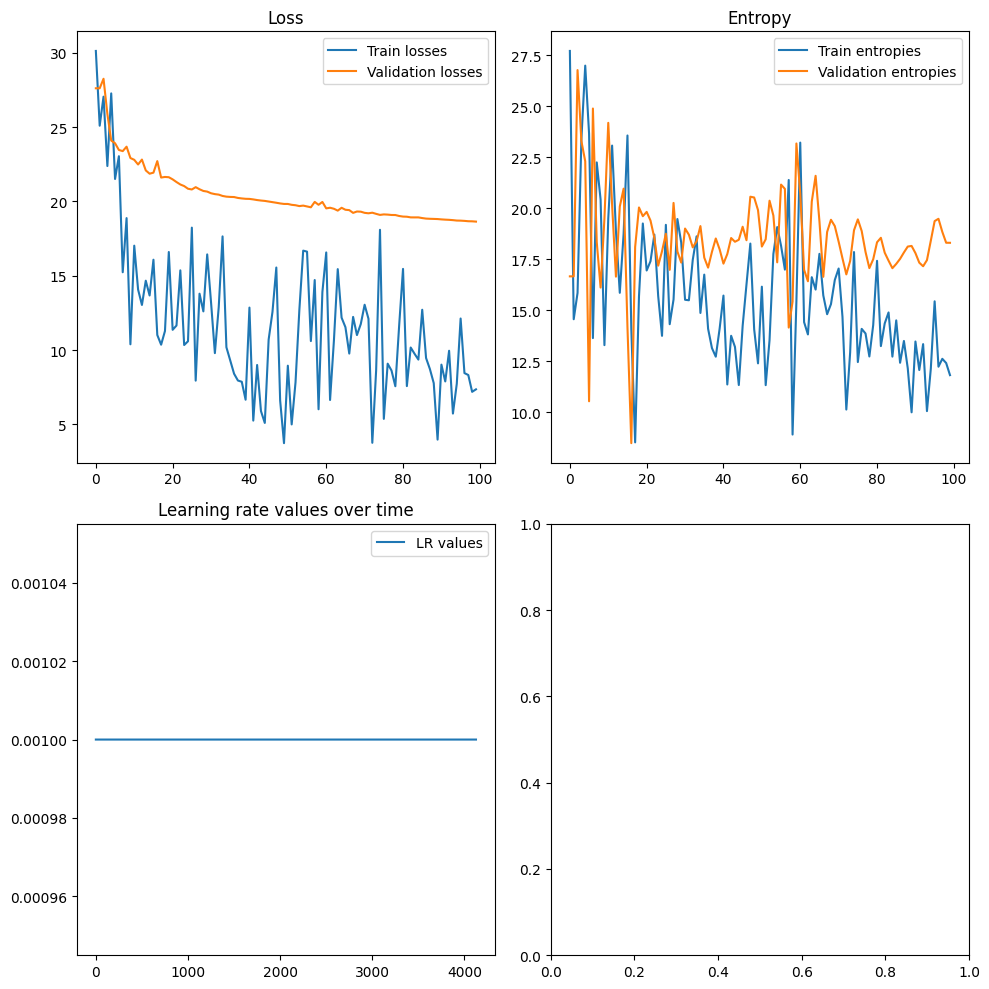

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

axes[0].plot(train_losses, label="Train losses")
axes[0].plot(valid_losses, label="Validation losses")
axes[0].set_title("Loss")
axes[0].legend()

axes[1].plot(train_entropies, label="Train entropies")
axes[1].plot(valid_entropies, label="Validation entropies")
axes[1].set_title("Entropy")
axes[1].legend()

axes[2].plot(learning_rates, label="LR values")
axes[2].set_title("Learning rate values over time")
axes[2].legend()

plt.tight_layout()

plt.show()